In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
%matplotlib inline
import seaborn as sns

sns.set_style('darkgrid')

# Context

In [2]:
%%html
<style>
  table {margin-left: 0 !important}
</style>

**Problem**: explore what sorts of people were more likely to survive the Titanic shipwreck using passenger data.  
**Dataset**: train.csv from https://www.kaggle.com/c/tabular-playground-series-apr-2021/data

The dataset provides following information about a passenger:  

| Variable | Definition                                 |  Key                                           |
| :------- | :----------------------------------------- | :--------------------------------------------- |
| Survived | Target variable                            | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger Fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |     


**Variable Notes:**    
Pclass: a proxy for socio-economic status (SES):  
1st = Upper  
2nd = Middle  
3rd = Lower

Age: age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

SibSp: the dataset defines family relations in this way:    
Sibling = brother, sister, stepbrother, stepsister  
Spouse = husband, wife (mistresses and fiancés were ignored)

Parch: the dataset defines family relations in this way:  
Parent = mother, father  
Child = daughter, son, stepdaughter, stepson  
Some children travelled only with a nanny, therefore parch=0 for them.

### Initial hypotheses/investigation themes to explore
- "women and children first" rule
- age effect on surviving. In particular, children and women aged 20 to 35 (child-bearing age)
- SES effect on surviving. Did the first- and second-class passengers have any advantages? 
- Check correlation between Pclass and Fare (does higher SES imply more expensive tickets?), Pclass and Port of Emabrkation (different classes - different ports?)

# Data quality assessment

In [3]:
data = pd.read_csv('train.csv', header=0, index_col='PassengerId')
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [4]:
data.shape

(100000, 11)

**Number of observations**: 100000  
**Number of variables**: 11 (out of which one (**Survived**) is target variable)

## Missing data

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       96708 non-null   float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    95377 non-null   object 
 8   Fare      99866 non-null   float64
 9   Cabin     32134 non-null   object 
 10  Embarked  99750 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 9.2+ MB


In [6]:
pd.DataFrame({
    'Missing': data.isna().sum(),
    'Missing(%)': (data.isna().sum() / data.shape[0]) * 100
}).sort_values(by='Missing', ascending=False)

,Missing,Missing(%)
Cabin,67866,67.866
Ticket,4623,4.623
Age,3292,3.292
Embarked,250,0.250
Fare,134,0.134
Survived,0,0.000
Pclass,0,0.000
Name,0,0.000
Sex,0,0.000
SibSp,0,0.000


Total number of missing values:

In [7]:
print(f'Missing cells: {data.isna().sum().sum()}')
print(f'Missing cells(%): {round((data.isna().sum().sum() / (data.shape[0] * data.shape[1])) * 100, 2)}%')

Missing cells: 76165
Missing cells(%): 6.92%


<AxesSubplot:>

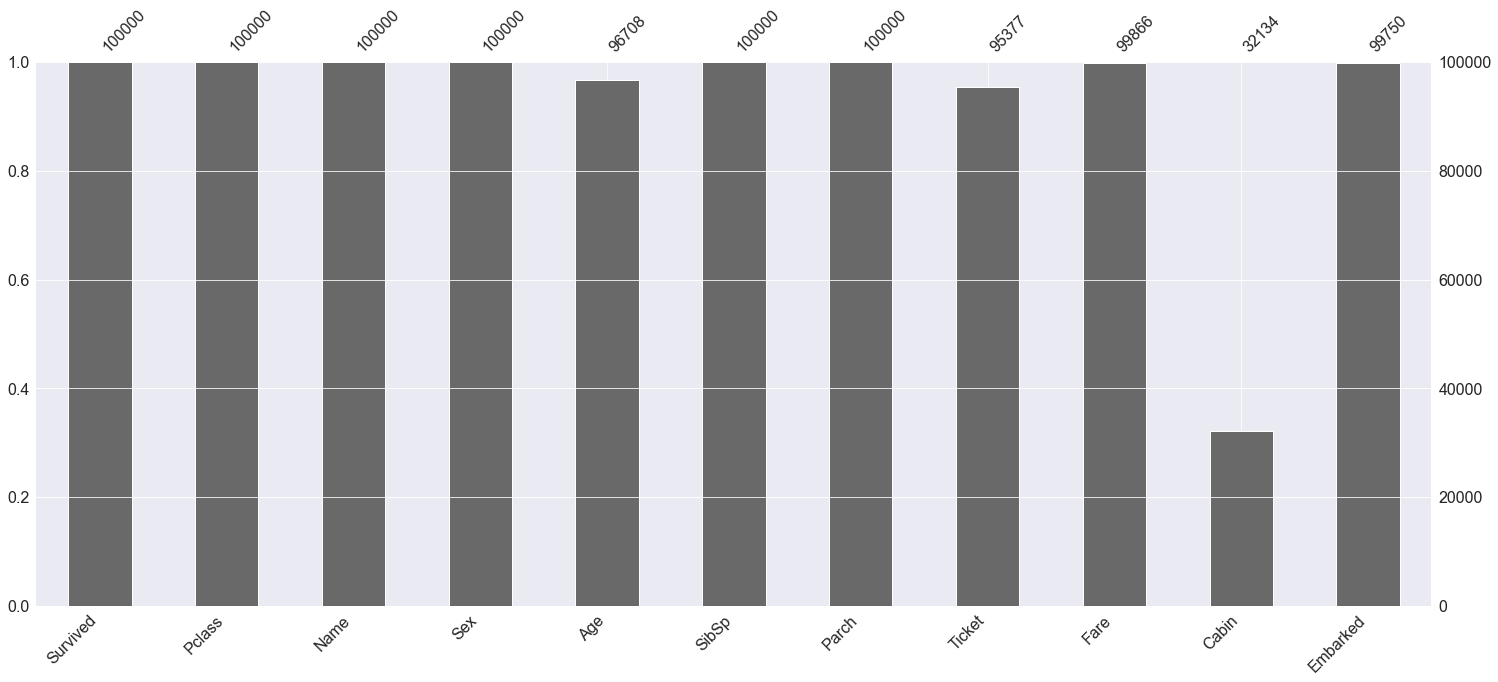

In [8]:
msno.bar(data)

<AxesSubplot:>

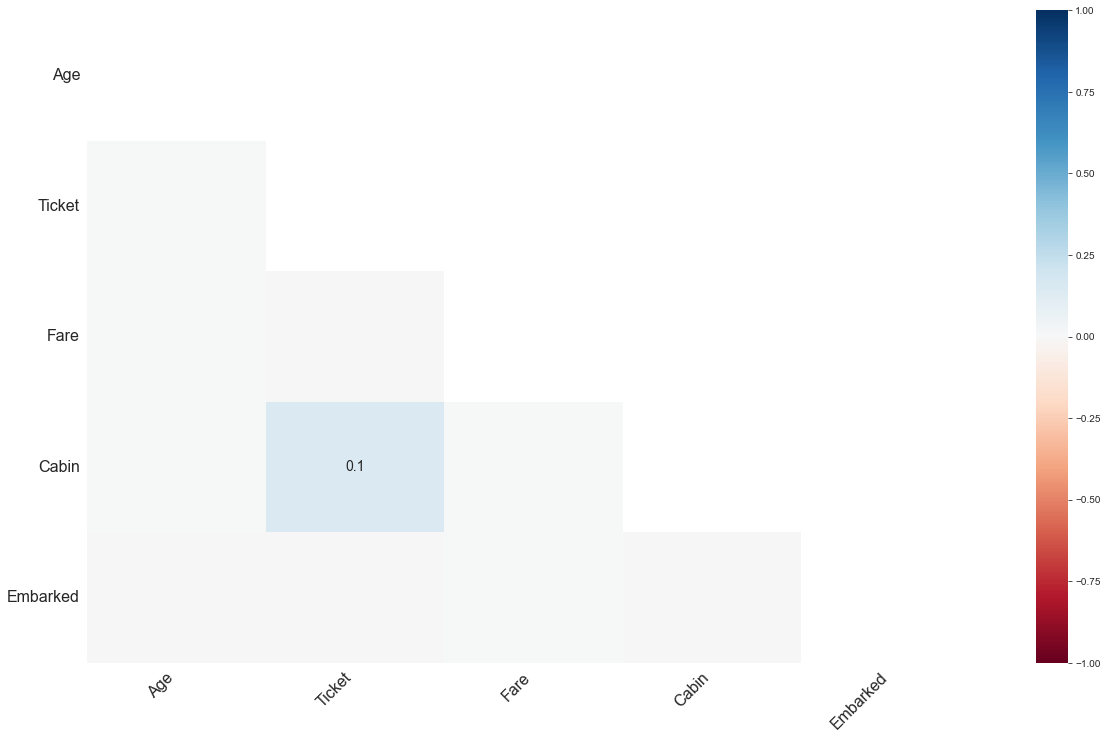

In [9]:
msno.heatmap(data)

There is no correlation between the missing values (there is a slight correlation between the values of Сabin and Ticket, but I guess it's only because there are a lot of missing values in Cabin column itself).


### Questions to consider
- Cabin column makes most of the missing values. Is there any specific reason for it? Maybe passengers with cheaper tickets don't have cabins and missing value actually means "no cabin"?
- Is there any pattern among passengers with missing ticket? Could passengers with missing ticket value belong to the ship crew? If yes, does the crew have a greater/lesser chance of survival?

## Duplicate rows

In [10]:
data.duplicated().sum()

0

## Variable types

In [11]:
data.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

Select numeric columns:

In [12]:
num_cols = data.select_dtypes(include='number').columns.tolist()
num_cols

['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

Select categorical columns:

In [13]:
cat_cols = data.columns.drop(num_cols).tolist()
cat_cols

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

**Parch** and **SibSp** take discrete number of values and, thus, can be considered either numerical or categorical.  
**Survived** and **Pclass** are numerical but should be categorical based on their values:

In [14]:
num_cols.remove('Survived')
num_cols.remove('Pclass')
cat_cols.append('Survived')
cat_cols.append('Pclass')

print(f'Number of categorical variables: {len(cat_cols)}')
print(f'Number of numeric variables: {len(num_cols)}')

Number of categorical variables: 7
Number of numeric variables: 4


### Numeric variables

In [15]:
num_cols

['Age', 'SibSp', 'Parch', 'Fare']

**SibSp** and **Parch** are **discrete** variables. Lets assess number of distinct values, percent of unique, min and max values:

**SibSp:**

In [16]:
pd.DataFrame({
    'count': data['SibSp'].value_counts(),
    'frequency(%)': (data['SibSp'].value_counts() / data.shape[0]) * 100
})

,count,frequency(%)
0,73308,73.308
1,19758,19.758
2,3703,3.703
3,1635,1.635
4,1168,1.168
8,296,0.296
5,132,0.132


In [17]:
print(f'Distinct: {len(data["SibSp"].value_counts())}')
print(f'Distinct(%): {round((len(data["SibSp"].value_counts()) / data.shape[0]) * 100, 2)}%')
print(f'Minimum: {data["SibSp"].min()}')
print(f'Maximum: {data["SibSp"].max()}')

Distinct: 7
Distinct(%): 0.01%
Minimum: 0
Maximum: 8


Most of passengers traveled without siblings and spouses.  
Almost 20% traveled with 1 Sibling/Spouse.
Max number of SibSp is 8.

**Parch:**

In [18]:
pd.DataFrame({
    'count': data['Parch'].value_counts(),
    'frequency(%)': (data['Parch'].value_counts() / data.shape[0]) * 100
})

,count,frequency(%)
0,73540,73.540
1,12996,12.996
2,11236,11.236
3,983,0.983
4,446,0.446
5,331,0.331
9,264,0.264
6,204,0.204


In [19]:
print(f'Distinct: {len(data["Parch"].value_counts())}')
print(f'Distinct(%): {round((len(data["Parch"].value_counts()) / data.shape[0]) * 100, 2)}%')
print(f'Minimum: {data["Parch"].min()}')
print(f'Maximum: {data["Parch"].max()}')

Distinct: 8
Distinct(%): 0.01%
Minimum: 0
Maximum: 9


Most of passengers traveled without parents and children.    
Almost 13% traveled with 1 Parent/Child.  
11% traveled with 2 Parents/Children.  
Max number of Parch is 9.

### Questions to consider
- Does having a family affect survival? Maybe people with a family had a higher chance of survival because they were rescued all together while the lonely ones were waiting for their turn

**Age** and **Fare** are **continuous** variables. Lets assess number of distinct values, percent of unique, min and max values and some descriptive statistics:

**Age:**

In [20]:
data['Age'].describe()

count    96708.000000
mean        38.355472
std         18.313556
min          0.080000
25%         25.000000
50%         39.000000
75%         53.000000
max         87.000000
Name: Age, dtype: float64

In [21]:
print(f'Distinct: {len(data["Age"].value_counts())}')
print(f'Distinct(%): {round((len(data["Age"].value_counts()) / data.shape[0]) * 100, 2)}%')
print(f'Missing: {data["Age"].isna().sum()}')
print(f'Missing(%): {(data["Age"].isna().sum() / data.shape[0]) * 100}%')
print(f'Minimum: {data["Age"].min()}')
print(f'Maximum: {data["Age"].max()}')
print(f'Mean: {round(data["Age"].mean())}')
print(f'Median: {round(data["Age"].median())}')
IQR = data["Age"].describe()['75%'] - data["Age"].describe()['25%']
print(f'Interquartile range: {IQR}')

Distinct: 173
Distinct(%): 0.17%
Missing: 3292
Missing(%): 3.292%
Minimum: 0.08
Maximum: 87.0
Mean: 38
Median: 39
Interquartile range: 28.0


**Fare:**

In [22]:
data['Fare'].describe()

count    99866.00000
mean        43.92933
std         69.58882
min          0.68000
25%         10.04000
50%         24.46000
75%         33.50000
max        744.66000
Name: Fare, dtype: float64

In [23]:
print(f'Distinct: {len(data["Fare"].value_counts())}')
print(f'Distinct(%): {round((len(data["Fare"].value_counts()) / data.shape[0]) * 100, 2)}%')
print(f'Missing: {data["Fare"].isna().sum()}')
print(f'Missing(%): {(data["Fare"].isna().sum() / data.shape[0]) * 100}%')
print(f'Minimum: {data["Fare"].min()}')
print(f'Maximum: {data["Fare"].max()}')
print(f'Mean: {round(data["Fare"].mean())}')
print(f'Median: {round(data["Fare"].median())}')

Distinct: 15935
Distinct(%): 15.93%
Missing: 134
Missing(%): 0.134%
Minimum: 0.68
Maximum: 744.66
Mean: 44
Median: 24


Mean(44) and Median(24) values significantly differ from Max(745). 75% of fare data is less than 33.5. It means we have a lot of outliers. Did outliers have a higher chance to survive?  

We will explore distribution of **Age** and **Fare** in next section.

### Categorical/Binary variables
To do: count distinct, assess unique values

In [24]:
cat_cols

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Survived', 'Pclass']

**Survived:**

In [25]:
pd.DataFrame({
    'count': data['Survived'].value_counts(),
    'frequency(%)': (data['Survived'].value_counts() / data.shape[0]) * 100
})

,count,frequency(%)
0,57226,57.226
1,42774,42.774


**Binary** variable.  
More people died than survived, but the difference is not too big.

**Sex:**

In [26]:
pd.DataFrame({
    'count': data['Sex'].value_counts(),
    'frequency(%)': (data['Sex'].value_counts() / data.shape[0]) * 100
})

,count,frequency(%)
male,56114,56.114
female,43886,43.886


**Binary** variable.  
There were more men on the ship.

**Pcalss:**

In [27]:
pd.DataFrame({
    'count': data['Pclass'].value_counts(),
    'frequency(%)': (data['Pclass'].value_counts() / data.shape[0]) * 100
})

,count,frequency(%)
3,41006,41.006
1,30315,30.315
2,28679,28.679


Values can be sorted. It is an **ordinal** variable.  
There were more 3-class passengers.

**Embarked:**

In [28]:
pd.DataFrame({
    'count': data['Embarked'].value_counts(),
    'frequency(%)': (data['Embarked'].value_counts() / data.shape[0]) * 100
})

,count,frequency(%)
S,72139,72.139
C,22187,22.187
Q,5424,5.424


Categorical variable without order or priority.  
Most of passengers embarked from Southampton. Maybe this value will be correlated with survival because of large proportion.

**Name:**

In [29]:
data['Name'].value_counts()

Johnson, John        31
Smith, James         24
Smith, John          24
Johnson, William     22
Smith, Michael       20
                     ..
Davis, Andre          1
Rosenblum, Ronald     1
Landry, Ernesto       1
Mcdonald, Frances     1
Enciso, Tyler         1
Name: Name, Length: 92144, dtype: int64

In [30]:
print(f'Distinct: {len(data["Name"].value_counts())}')
print(f'Missing: {data["Name"].isna().sum()}')
print(f'Missing(%): {(data["Name"].isna().sum() / data.shape[0]) * 100}%')

Distinct: 92144
Missing: 0
Missing(%): 0.0%


Variable with high cardinality.

**Ticket:**

In [31]:
data['Ticket'].value_counts()

A/5             602
C.A.            177
SC/PARIS        145
SOTON/O.Q.       80
SC               57
               ... 
421812            1
PC 420601         1
PC 26800          1
STON/O 23755      1
458074            1
Name: Ticket, Length: 75331, dtype: int64

In [32]:
print(f'Distinct: {len(data["Ticket"].value_counts())}')
print(f'Missing: {data["Ticket"].isna().sum()}')
print(f'Missing(%): {(data["Ticket"].isna().sum() / data.shape[0]) * 100}%')

Distinct: 75331
Missing: 4623
Missing(%): 4.623%


Variable with high cardinality.

**Cabin:**

In [33]:
data['Cabin'].value_counts()

C19828    6
C6906     5
C13699    5
C14534    5
B11110    5
         ..
A21234    1
A4905     1
C7208     1
A5788     1
D17243    1
Name: Cabin, Length: 26992, dtype: int64

In [34]:
print(f'Distinct: {len(data["Cabin"].value_counts())}')
print(f'Missing: {data["Cabin"].isna().sum()}')
print(f'Missing(%): {(data["Cabin"].isna().sum() / data.shape[0]) * 100}%')

Distinct: 26992
Missing: 67866
Missing(%): 67.866%


Variable with high cardinality.  
A lot of missing values.

We will explore these variables deeper in next section.

# Data exploration

## 1. Exploring each individual variable

### 1.1 Numerical variables

In [35]:
data[num_cols].describe()

,Age,SibSp,Parch,Fare
count,96708.000000,100000.000000,100000.000000,99866.00000
mean,38.355472,0.397690,0.454560,43.92933
std,18.313556,0.862566,0.950076,69.58882
min,0.080000,0.000000,0.000000,0.68000
25%,25.000000,0.000000,0.000000,10.04000
50%,39.000000,0.000000,0.000000,24.46000
75%,53.000000,1.000000,1.000000,33.50000
max,87.000000,8.000000,9.000000,744.66000


**SibSp** and **Parch** are numeric, but take discrete number of values. We will visualize them using countplot:

<AxesSubplot:xlabel='Parch', ylabel='count'>

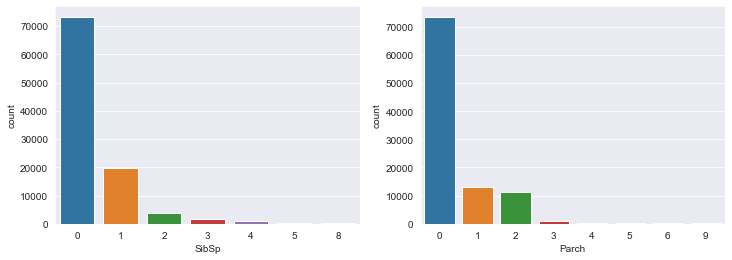

In [36]:
_, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.countplot(data=data, x='SibSp', ax=axes[0])
sns.countplot(data=data, x='Parch', ax=axes[1])

Text(-7.324999999999996, 0.5, 'Count')

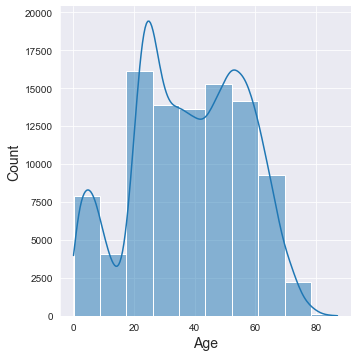

In [37]:
sns.displot(data=data, x='Age', kde=True, bins=10)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Count', fontsize=14)

Most of passengers lie in the range 20-60 years. The first bin is quite noticeable too.  

Maybe it makes sense to create a new categorical variable - the age group - and label all passengers with corresponding age group for further exploration.

Text(-7.324999999999996, 0.5, 'Count')

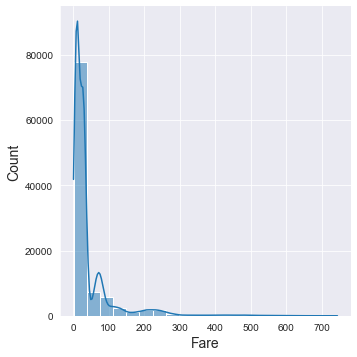

In [38]:
sns.displot(data=data, x='Fare', kde=True, bins=20)
plt.xlabel('Fare', fontsize=14)
plt.ylabel('Count', fontsize=14)

Variable Fare skewed right. Lets have a closer look to its statistics:

In [39]:
data['Fare'].describe()

count    99866.00000
mean        43.92933
std         69.58882
min          0.68000
25%         10.04000
50%         24.46000
75%         33.50000
max        744.66000
Name: Fare, dtype: float64

<AxesSubplot:xlabel='Fare'>

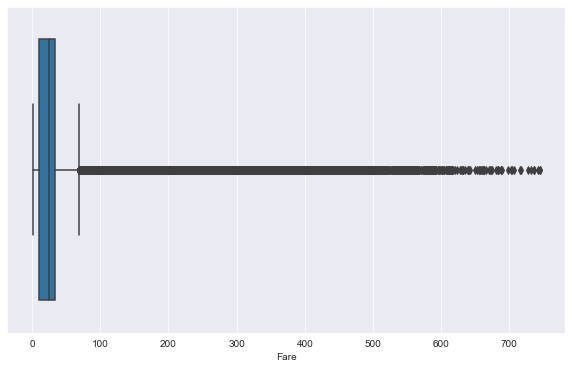

In [40]:
plt.figure(figsize=(10,6))
sns.boxplot(data=data, x='Fare')

In [41]:
data[data['Fare'] <= data['Fare'].describe()['75%']].shape[0]

74907

In [42]:
IQR = data['Fare'].describe()['75%'] - data['Fare'].describe()['25%'] # interquartile range
data[data['Fare'] > data['Fare'].describe()['75%'] + 1.5 * IQR].shape[0]

17161

In [43]:
(data[data['Fare'] > data['Fare'].describe()['75%'] + 1.5 * IQR].shape[0] / data.shape[0]) * 100

17.161

Median (24.5) significantly differs from max (745). 75% of fare data is less than 33.5.  
17.161% of passengers are outliers. Did they have more chances to survive?  
We will explore later how Fare correlates survival.

### 1.2 Categorical variables

<AxesSubplot:xlabel='Sex', ylabel='count'>

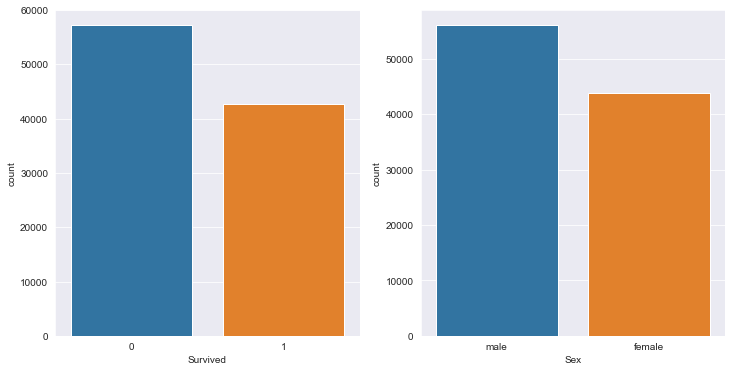

In [44]:
_, axes = plt.subplots(1, 2, figsize=(12,6))
sns.countplot(data=data, x='Survived', ax=axes[0])
sns.countplot(data=data, x='Sex', ax=axes[1])

Classes are slightly imbalanced.

<AxesSubplot:xlabel='Embarked', ylabel='count'>

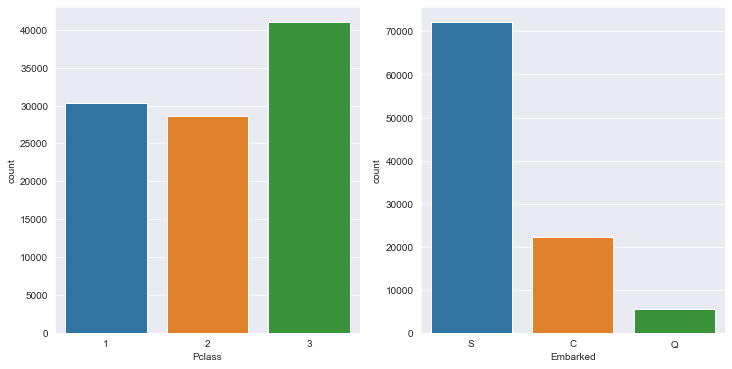

In [45]:
_, axes = plt.subplots(1, 2, figsize=(12,6))
sns.countplot(data=data, x='Pclass', ax=axes[0])
sns.countplot(data=data, x='Embarked', ax=axes[1])

Most of passengers belonged to 3-class.  
Majority of passengers embarked in Southhampton and only few of them embarked in Queenstown. 
We will explore relationships between Pclass, Embarked and survival in next section.

**Name**, **Ticket** and **Cabin** have a lot of unique values. They are strings and cannot be categorized.  
Name values don't tell us anything useful and can be dropped.  
But we still have Cabin and Ticket with a lot of missing values. We will investigate them deeper in next section.

## 2. Exploring the relationship between each variable and the target

Our target variable **Survived** is categorical. We will explore **continuous x categorical** and **categorical x categorical** relationships.

### 2.1 Continuous x Categorical

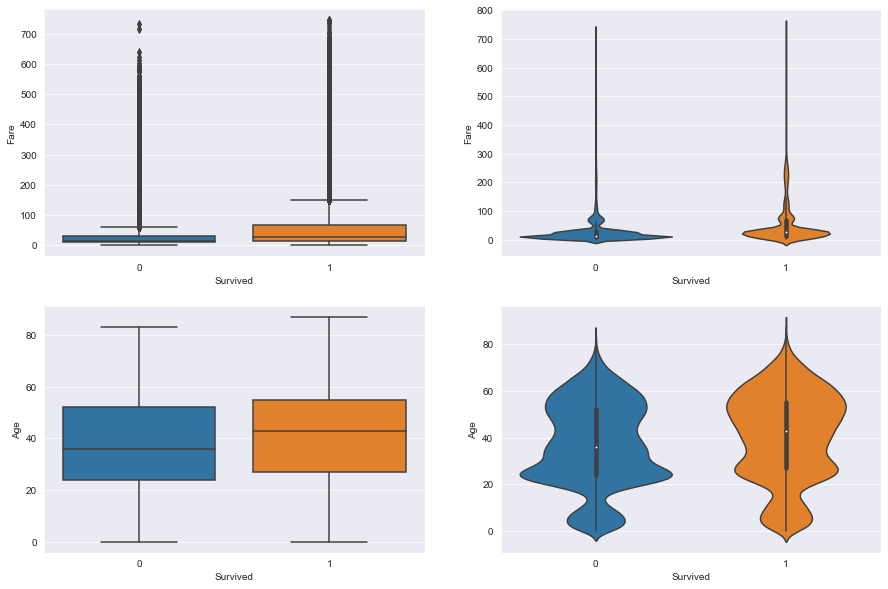

In [46]:
_, axes = plt.subplots(2, 2, figsize=(15, 10))
for idx, col in enumerate(['Fare', 'Age']):
    sns.boxplot(data=data, x='Survived', y=col, ax=axes[idx, 0])
    sns.violinplot(data=data, x='Survived', y=col, ax=axes[idx, 1])

Passengers with bigger **Fare** had more chances ro survive.  
Seems that chances of survival increase with age.
Let's divide these continuous variables into the corresponding groups (age range and fare range) and analyze them again:

**Age range:**

<AxesSubplot:xlabel='AgeRange', ylabel='Survived'>

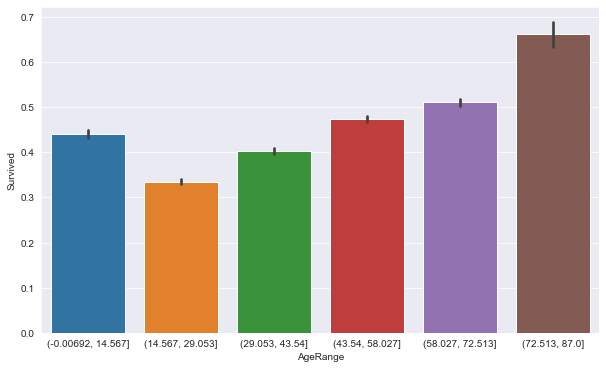

In [47]:
# Divide Age into 6 bins
data['AgeRange'] = pd.cut(data['Age'], 6)

plt.figure(figsize=(10,6))
sns.barplot(data=data, x ='AgeRange', y ='Survived')

In [48]:
pd.DataFrame({
    'Count': data['AgeRange'].value_counts(),
    'Frequency(%)': (data['AgeRange'].value_counts() / data.shape[0]) * 100
})

,Count,Frequency(%)
"(43.54, 58.027]",26215,26.215
"(14.567, 29.053]",23023,23.023
"(29.053, 43.54]",21752,21.752
"(58.027, 72.513]",13747,13.747
"(-0.00692, 14.567]",10852,10.852
"(72.513, 87.0]",1119,1.119


Children under the age of 15 have a better chance of survival than the group aged 15-29 years (although the number of passengers belonging to the second group is more than twice as large).  
After 29, the chances of survival increase with age. The smallest group of 72-87 has quite high chance of survival.  
It means **Age** column is important for predicting and missing values need to be filled (for example using nearest neighbor imputation).

**Fare range:**

<AxesSubplot:xlabel='FareRange', ylabel='Survived'>

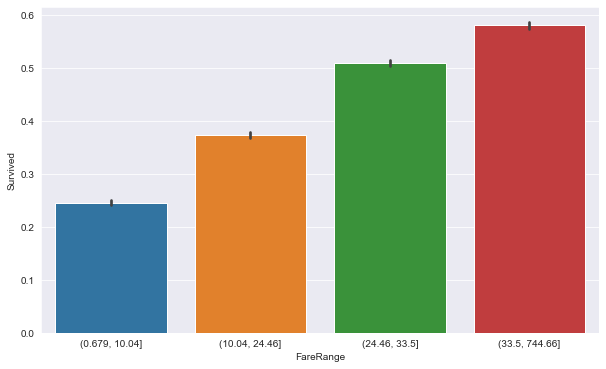

In [49]:
data['FareRange'] = pd.qcut(data['Fare'], 4)

plt.figure(figsize=(10,6))
sns.barplot(data=data, x ='FareRange', y ='Survived')

In [50]:
pd.DataFrame({
    'Count': data['FareRange'].value_counts(),
    'Frequency(%)': (data['FareRange'].value_counts() / data.shape[0]) * 100
})

,Count,Frequency(%)
"(0.679, 10.04]",25033,25.033
"(24.46, 33.5]",24968,24.968
"(33.5, 744.66]",24959,24.959
"(10.04, 24.46]",24906,24.906


The chances of survival increase with higher fare. Group of outliers indeed had the biggest chance of survival.   
It means **Fare** column is important for predicting and missing values need to be filled (median value seems reasonble).

### 2.2 Categorical x Categorical

As we saw earlier, variables **Parch** and **SibSp** take discrete number of values and, thus, can be considered either numerical or categorical. We have already seen their distributions with a count plot. Now, we are interested in the relationship between these variables and the target variable:

<AxesSubplot:xlabel='Parch', ylabel='count'>

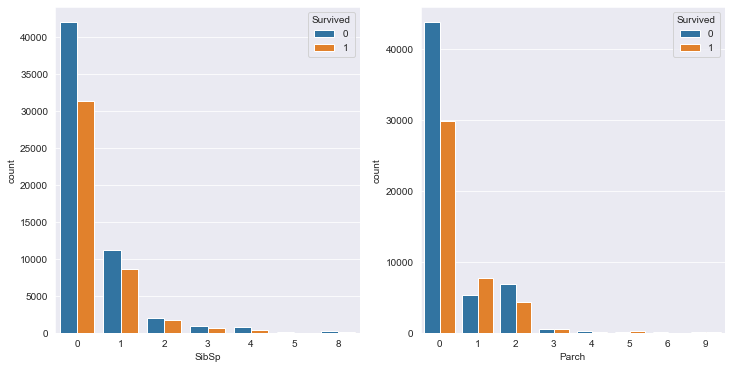

In [51]:
_, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(data=data, x='SibSp', hue='Survived', ax=axes[0])
sns.countplot(data=data, x='Parch', hue='Survived', ax=axes[1])

<AxesSubplot:xlabel='Parch', ylabel='Survived'>

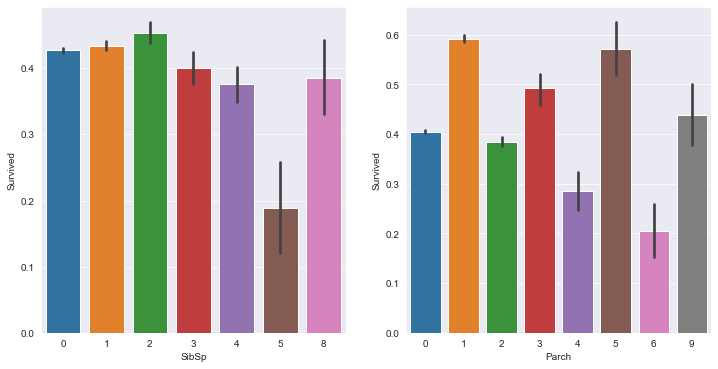

In [73]:
_, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(data=data, x='SibSp', y='Survived', ax=axes[0])
sns.barplot(data=data, x='Parch', y='Survived', ax=axes[1])

Passengers with **Parch** = 1 have more chances to survive (probably it was a combination mother+children).  
Seems that **SibSp** number doesn't contribute a lot to survival.
But lets combine both variables into **FamilySize** and analyze again:

In [53]:
data['FamilySize'] = data['SibSp'] + data['Parch']

<AxesSubplot:xlabel='FamilySize', ylabel='Survived'>

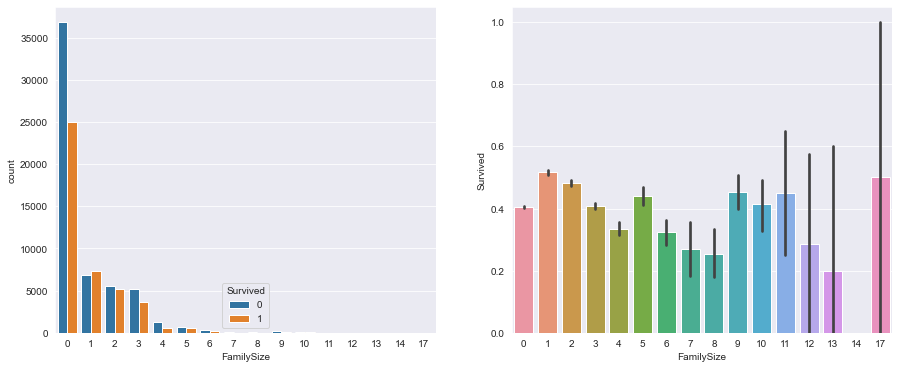

In [54]:
_, axes = plt.subplots(1, 2, figsize=(15,6))
sns.countplot(data=data, x='FamilySize', hue='Survived', ax=axes[0])
sns.barplot(data=data, x='FamilySize', y='Survived', ax=axes[1])

Passengers with small number of family members (1-3) had sligthly bigger chance of survival than lonely ones, but this chance decreases with bigger family.

**Sex:**

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

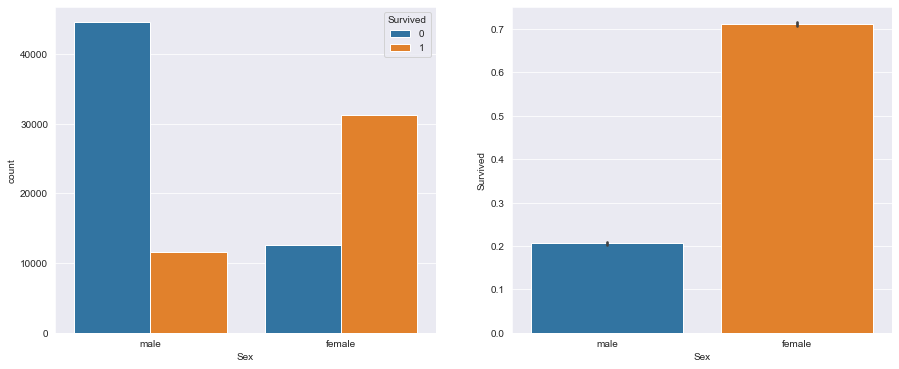

In [55]:
_, axes = plt.subplots(1, 2, figsize=(15,6))
sns.countplot(data=data, x='Sex', hue='Survived', ax=axes[0])
sns.barplot(data=data, x='Sex', y='Survived', ax=axes[1])

**Sex** is a very strong predictor of survival (female had a bigger chance).

**Pclass:**

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

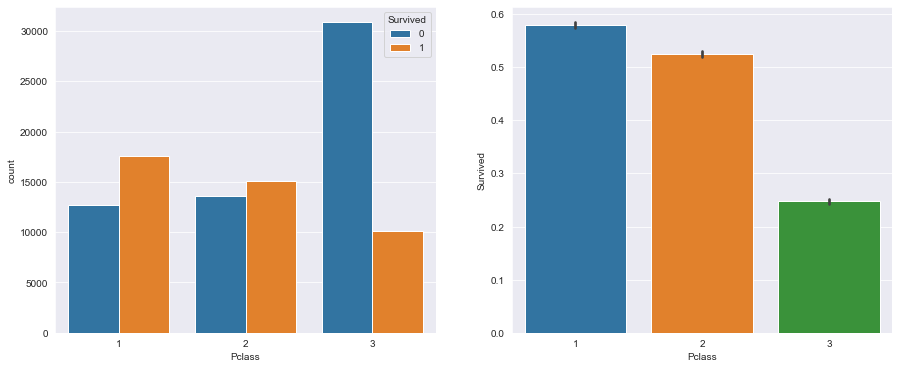

In [56]:
_, axes = plt.subplots(1, 2, figsize=(15,6))
sns.countplot(data=data, x='Pclass', hue='Survived', ax=axes[0])
sns.barplot(data=data, x='Pclass', y='Survived', ax=axes[1])

**Pclass** is good predictor of survival.  
1- and 2-class passengers had advantage.

**Embarked:**

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

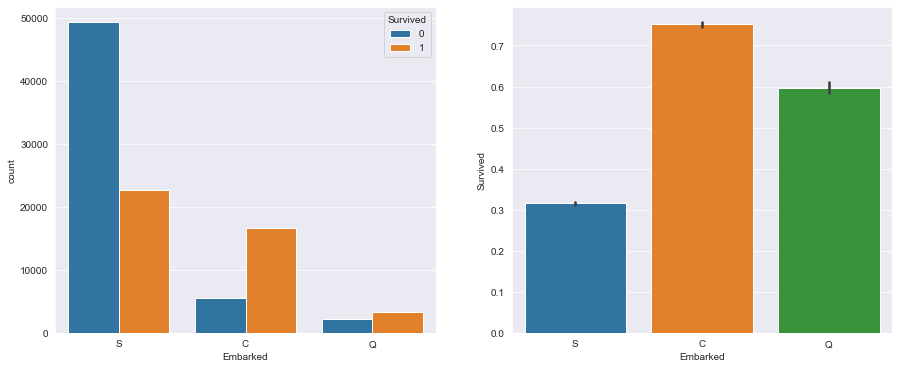

In [57]:
_, axes = plt.subplots(1, 2, figsize=(15,6))
sns.countplot(data=data, x='Embarked', hue='Survived', ax=axes[0])
sns.barplot(data=data, x='Embarked', y='Survived', ax=axes[1])

**Embarked** is good predictor of survival.  
Passengers embarked from 'C' and 'Q' ports had advantage.  
It means **Embarked** column is important for predicting and missing values need to be filled (most frequent value - 'S' - seems reasonble).

As we remember from previous part, most of passengers embarked from 'S' and belonged to 3-class.  
We will explore relationship between Pclass and Embarked in next part.

**Cabin:**

Lets create new binary feature **HasCabin** and assign 0 to all missing Cabin values:

In [58]:
data['HasCabin']= data['Cabin'].fillna(0)
data['HasCabin'].where(data['HasCabin'] == 0, 1, inplace=True)

<AxesSubplot:xlabel='HasCabin', ylabel='Survived'>

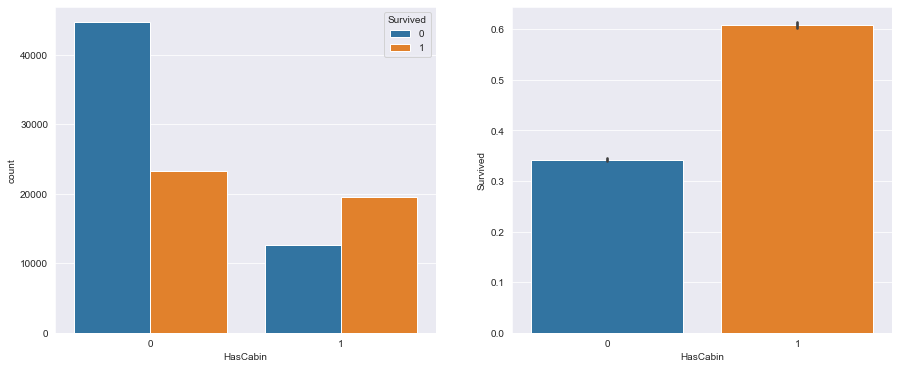

In [59]:
_, axes = plt.subplots(1, 2, figsize=(15,6))
sns.countplot(data=data, x='HasCabin', hue='Survived', ax=axes[0])
sns.barplot(data=data, x='HasCabin', y='Survived', ax=axes[1])

Having a Cabin is a good predictor for survival.  
But is it really acceptable to assume that the missing values of the cabin imply its absence?  We will try to prove this assumption by looking for relationship between Cabin and Fare, Cabin and Pclass in next section.

**Ticket**:

Could passengers with missing ticket value have smth in common(for example, they belong to the ship crew)? If yes, did they have a greater/lesser chance of survival?  
To check this idea we will create new binary feature **HasTicket** and assign 0 to all missing Ticket values:

In [60]:
data['HasTicket']= data['Ticket'].fillna(0)
data['HasTicket'].where(data['HasTicket'] == 0, 1, inplace=True)

<AxesSubplot:xlabel='HasTicket', ylabel='Survived'>

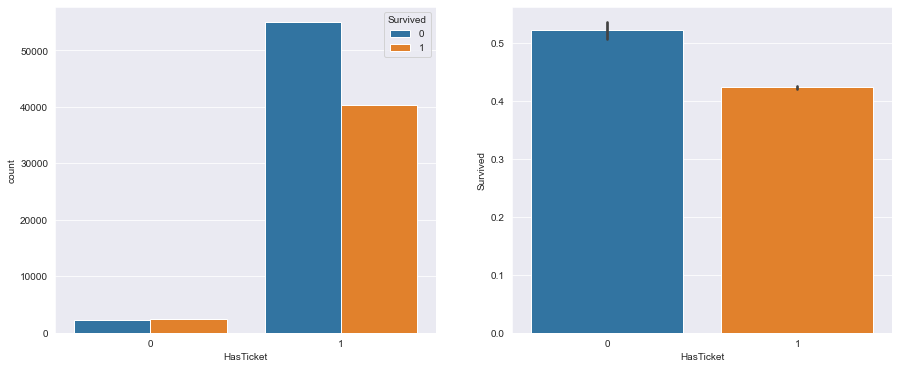

In [61]:
_, axes = plt.subplots(1, 2, figsize=(15,6))
sns.countplot(data=data, x='HasTicket', hue='Survived', ax=axes[0])
sns.barplot(data=data, x='HasTicket', y='Survived', ax=axes[1])

Seems that passsengers with missing ticket value indeed had slightly bigger chances to survive.  
We can simply use this binary values in future instead of original Ticket values, because they are just strings and take a lot of unique values, which don't say anything useful.

## 3. Assessing interactions between variables

To conviniently represent interactions between variables using correlation matrix lets map Sex, Embarked, HasCabin and HasTicket to numerical values:

In [62]:
data['Sex_mapped'] = data['Sex'].map({
    'male': 0,
    'female': 1
})
data['Embarked_mapped'] = data['Embarked'].map({
    'S': 0,
    'C': 1,
    'Q': 2
})

data['HasCabin'] = data['HasCabin'].astype(int)
data['HasTicket'] = data['HasTicket'].astype(int)

<AxesSubplot:>

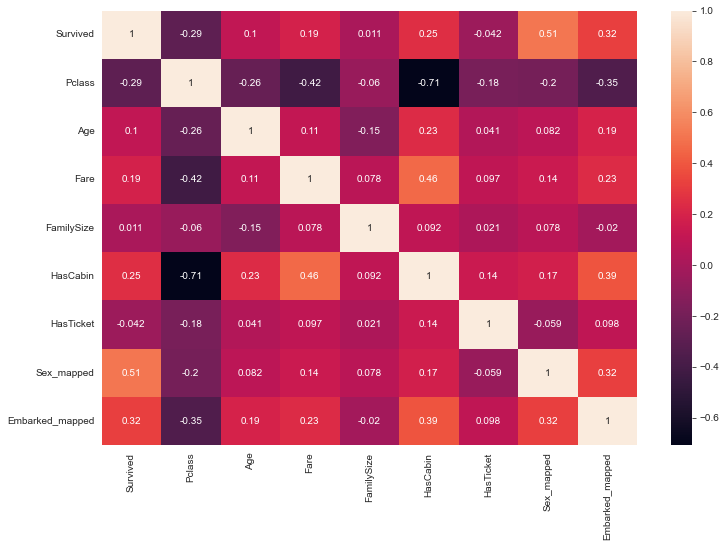

In [63]:
plt.figure(figsize=(12,8))
# we will drop 'SibSp' and 'Parch' columns because we created new column 'FamilySize'
sns.heatmap(data.drop(['SibSp', 'Parch'], axis=1).corr(), annot=True)

As we saw in previous part, **Survived** has very slight correlation (almost zero) with FamilySize and MissingTicket values.  
It is slightly correlated with Age.  
Correlated more with Fare, HasCabin, Pclass and Embarked.  
The strongest correllation is with Sex.

More interestingly, we see, that there is a strong correlation between **Pclass and HasCabin**, **Pclass and Fare**, **Pclass and Embarked**. Lets have a closer look: 

<AxesSubplot:xlabel='Pclass', ylabel='count'>

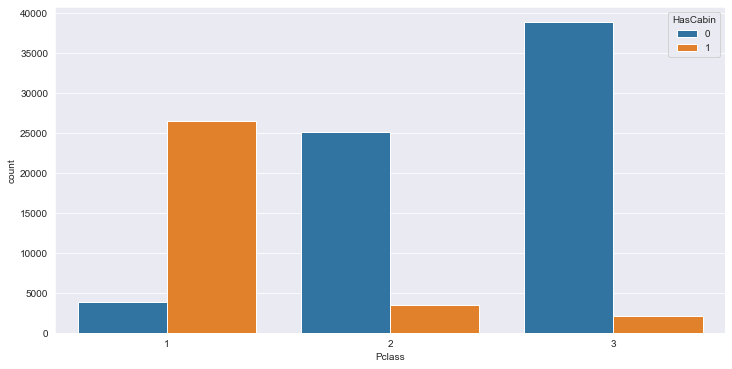

In [64]:
plt.figure(figsize=(12,6))
sns.countplot(data=data, x='Pclass', hue='HasCabin')

Most of 1-class passengers have cabins.  
A very small number of 3-class passengers have cabins.  
For 2-class passengers the ratio of presence of cabins to the absence is small, but still more than for 3-class passengers.

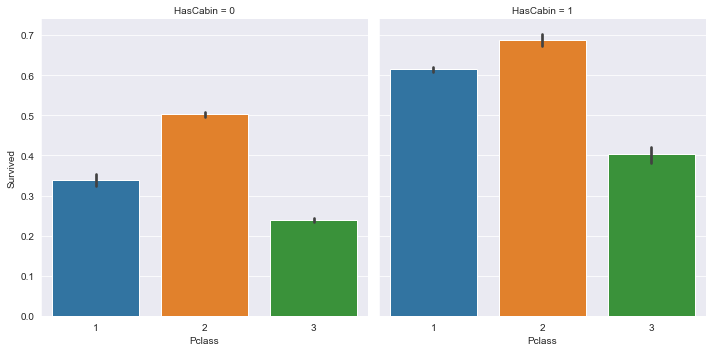

In [65]:
sns.catplot(data=data, x='Pclass', y='Survived', col='HasCabin', kind='bar')

The presence of a cabin indeed gives an advantage in survival for all classes.

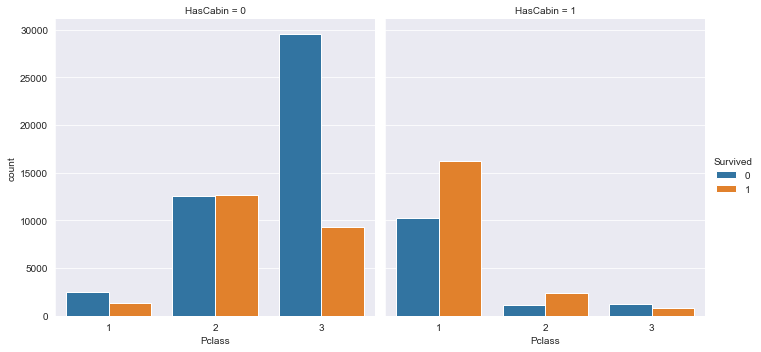

In [66]:
sns.catplot(data=data, x='Pclass', hue='Survived', col='HasCabin', kind='count')

This advantage is strongest for the 1-class, because they make up the majority among passengers that have cabins.

<AxesSubplot:xlabel='Embarked', ylabel='count'>

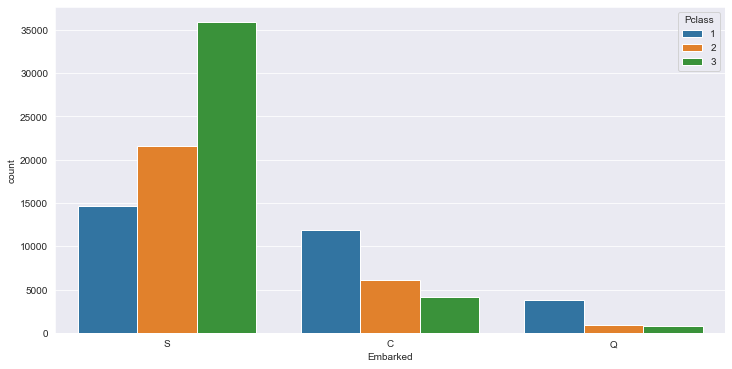

In [67]:
plt.figure(figsize=(12,6))
sns.countplot(data=data, x='Embarked', hue='Pclass')

Most of the passengers from port S are  3-class passengers.  
Most of the passengers from ports C and Q are 1- and 2-class passengers.
Thus, port of embarkation strongly associated with class.

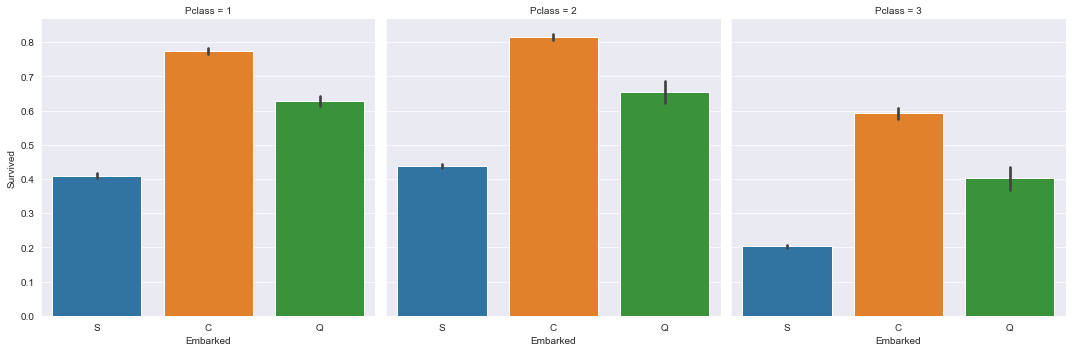

In [68]:
sns.catplot(data=data, x='Embarked', y='Survived', col='Pclass', kind='bar')

Ports C and Q give a survival advantage for passengers of all three classes.
But the survival rate for 3-class is generally lower than for 1- and 2-class, regardless of the port.  

The chance of survival is higher for 1- and 2-class from C and Q ports.

In [69]:
#sns.catplot(data=data, x ='Embarked', hue ='Survived', col ='Pclass',  kind ='count')

<AxesSubplot:xlabel='HasCabin', ylabel='Fare'>

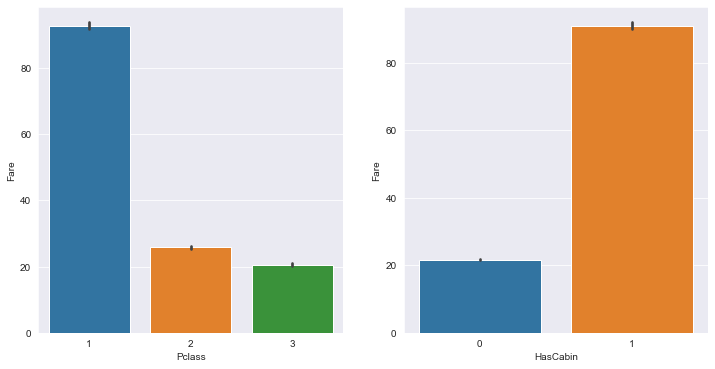

In [70]:
_, axes = plt.subplots(1, 2, figsize=(12,6))
sns.barplot(data=data, x='Pclass', y='Fare', ax=axes[0])
sns.barplot(data=data, x='HasCabin', y='Fare', ax=axes[1])

Fare tends to be higher for higher classes.  
Fare tends to be higher for places without missing Cabin values.

All mentioned conclusions mean that our theory about missing cabin values can be applied (missing values actually means no cabin, which can be explained with cheaper fare and lower class). Thus, we can simply use this binary values in future instead of original Cabin values, because they are just strings and take a lot of unique values, which don't say anything useful. 

Additionally we can examine distribution of sex and age by classes:

<AxesSubplot:xlabel='Pclass', ylabel='count'>

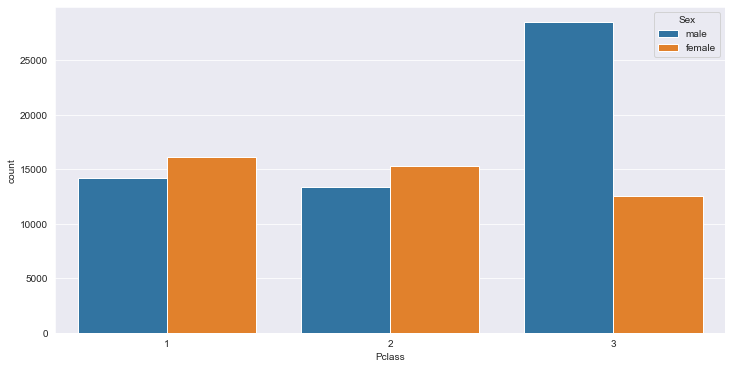

In [71]:
plt.figure(figsize=(12,6))
sns.countplot(data=data, x='Pclass', hue='Sex')

More female than male belong to the 1- and 2-class, which agrees with our previous conclusions (more female survived than male and more 1- and 2-class passengers than 3-class)

<AxesSubplot:xlabel='Sex', ylabel='Age'>

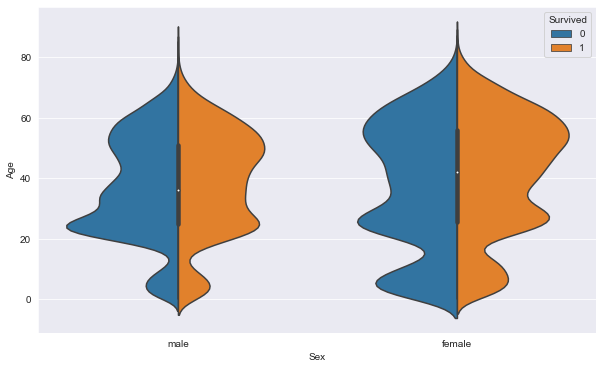

In [72]:
plt.figure(figsize=(10,6))
sns.violinplot(data=data, x='Sex', y='Age', hue='Survived', split=True)

The survival rate is:  
better for children than for teenagers,  
lower for teenagers, but gradually increase by the age of 20-25,  
higher for female as the age increases.

# Summary

- **Sex** is a very strong predictor of survival (female had more chances, while there were more man on the ship),
- **Pclass** is good predictor of survival (1- and 2-class passengers had more chances, while there were more 3-class passengers on the ship). More female than male belong to the 1- and 2-class,
- **Embarked** is good predictor of survival (passengers embarked from 'C' and 'Q' ports had more chances, while there were more passangers embarked from 'S' port). Missing values can be filled with most frequent value 'S'),  
- **Fare** is good predictor of survival (passengers with bigger Fare had more chances). 17.161% of column values are outliers that had the biggest chance of survival. Missing values can be filled with median value,
- **Cabin** column itself can be dropped because its values are just strings and take a lot of unique values, which don't say anything useful. Instead we can create new binary feature **HasCabin** and assign 0 to all missing Cabin values (because missing values actually means no cabin, which can be explained with cheaper fare and lower class). **HasCabin** is good predictor of survival (passengers with cabin had more chances),
- chances of survival increase with **Age**. Children under the age of 15 had a better chance of survival than the group aged 15-29 years (although the number of passengers belonging to the second group is more than twice as large). After 29, the chances of survival increase with age. The smallest group of 72-87 has quite high chance of survival. Missing values can be be filled using nearest neighbor imputation
- **SibSp** and **Parch** didn't contribute a lot to survival chances. Most of passengers traveled without siblings and spouses and most of passengers traveled without parents and children. But passengers with Parch = 1 had more chances of survival (probably it was a combination mother+children). Combining both variables into FamilySize gave us following information: passengers with small number of family members (1-3) had sligthly bigger chance of survival than lonely ones, but this chance decreases with bigger family,
- **Ticket** column itself can be dropped because its values are just strings and take a lot of unique values, which don't say anything useful. Instead we can create new binary feature **HasTicket** and assign 0 to all missing Ticket values. Passengers with missing ticket value had slightly bigger chances of survival (maybe they belonged to ship crew and had some advantages),
- **Name** column itself can be dropped because its values are just strings and take a lot of unique values, which don't say anything useful,

- there is a strong correlation between **Pclass and HasCabin** (most of 1-class passengers had cabins, very small number of 3-class passengers had cabins, for 2-class passengers the ratio of presence of cabins to the absence is small, but still more than for 3-class passengers), **Pclass and Fare** (fare tends to be higher for higher classes), **Pclass and Embarked** (most of the passengers embarked from port 'S' are 3-class passengers, most of the passengers embarked from ports 'C' and 'Q' are 1- and 2-class passengers). Thus, The chance of survival is higher for 1- and 2-class passengers embarked from 'C' and 'Q' ports.